# 1. Importing Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
import pandas

In [5]:
od.download('https://www.kaggle.com/datasets/harieh/ocr-dataset/')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aliyafatima032
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/harieh/ocr-dataset


100%|██████████| 153M/153M [00:01<00:00, 112MB/s]


# 2. Helper Functions & Hyperparameters

- This section is to define all Helper functions through the notebook and any hyperparameters used later for training the models.

In [6]:
def directory_to_df(path: '/content/ocr-dataset/dataset'):
  df = []
  chars = 'abcdefghijklmnopqrstuvwxyz' # to include lowercase letters only
  for cls in os.listdir(path):
    cls_path = os.path.join(path, cls)
    cls_name = cls.split('_')[0]
    if not cls_name in chars:
      continue
    for img_path in os.listdir(cls_path):
      direct = os.path.join(cls_path, img_path)
      df.append([direct, cls_name])

  df = pd.DataFrame(df, columns=['image', 'label'])
  print('The number of samples found: ', len(df))
  return df.copy()


In [63]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image



In [62]:
def show_image(img, label=None) -> None:
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()


In [9]:
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [10]:
# pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate = 0.00001, epsilon=1e-16)
loss = 'categorical_crossentropy'
EPOCHS = 10

# 3. Reading & preparing the dataset

In [11]:
# Reading the dataset in dataframe
main_path = '/content/ocr-dataset/dataset'
df = directory_to_df(main_path) #convert the dataset into df of two columns
df.head()


The number of samples found:  85199


,image,label
0,/content/ocr-dataset/dataset/u_L/U_L_3214.png,u
1,/content/ocr-dataset/dataset/u_L/U_L_2748.png,u
2,/content/ocr-dataset/dataset/u_L/U_L_831.png,u
3,/content/ocr-dataset/dataset/u_L/U_L_473.png,u
4,/content/ocr-dataset/dataset/u_L/U_L_3186.png,u


In [12]:
df['label'].value_counts()

,count
label,
e,3284
r,3284
n,3281
a,3281
m,3281
q,3279
u,3278
d,3277
i,3277


## 3.1 Splitting the dataframe

- The dataframe is splitted to get 70% of the dataset for `training` & 30% for `testing`.
- The training set is splitted into `training` & `vaidation` to enhance model tranining.

In [13]:
# splitting for training & testing (70, 30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 41)
training_df = pd.concat((X_train, y_train), axis=1)
testing_df = pd.concat((X_test, y_test), axis=1)

In [14]:
training_df.head()

,image,label
64309,/content/ocr-dataset/dataset/l_L/L_L_1703.png,l
4822,/content/ocr-dataset/dataset/v_L/V_L_2665.png,v
41804,/content/ocr-dataset/dataset/x_L/X_L_2685.png,x
67645,/content/ocr-dataset/dataset/t_L/T_L_1725.png,t
84614,/content/ocr-dataset/dataset/o_L/O_L_32.png,o


In [15]:
# Splitting for training & validation (75, 25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 41)
training_df = pd.concat((X_train, y_train), axis=1)
validation_df = pd.concat((X_valid, y_valid), axis=1)

## 3.2 Creating Generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also it enhances the RAM usage.

In [16]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [17]:
# Making a mapping of the classes & the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

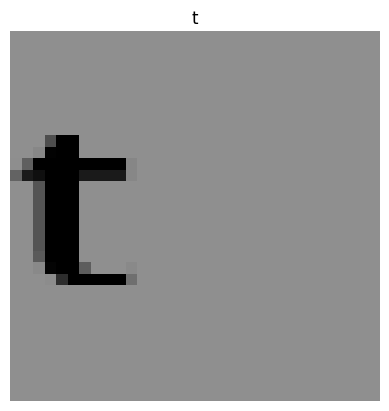

The shape of the image: (32, 32, 3)


In [18]:
# Reading a sample from the dataset.
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

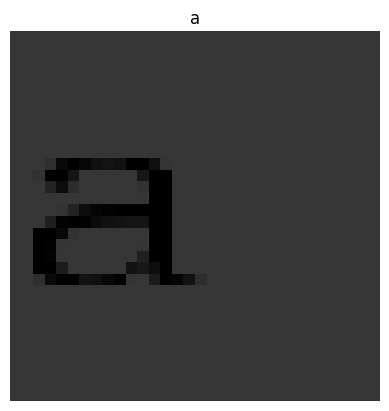

The shape of the image: (32, 32, 3)


In [19]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4. Modelling
Our target is to build a `custom CNN model` to train on our targeted images for the `OCR` application. In advance, I'll try to use 4 pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.

**The targeted pre-trained models are the following:**
- *EfficientNetB7*
- *MobileNetV2*
- *VGG19*
- *DenseNet121*

***The fine-tuning strategy:*** Using a small value of `LR` of the optimizer `Adam` will make an efficient use of pre-trained models on the dataset without **FREEZING** the input layers in which better performance is required in the case.

## 4.1 Custom CNN

In [20]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [21]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 32, 32, 3)           84        
                                                                 
 conv2d_1 (Conv2D)           (32, 30, 30, 128)         3584      
                                                                 
 max_pooling2d (MaxPooling2  (32, 10, 10, 128)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 8, 8, 256)           295168    
                                                                 
 dropout (Dropout)           (32, 8, 8, 256)           0         
                                                                 
 conv2d_3 (Conv2D)           (32, 4, 4, 256)           590080    
                                                        

In [22]:
#Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [23]:
# different num of epochs will be given for better convergence for the custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20
1398/1398 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.6521
Epoch 1: val_loss improved from inf to 0.45105, saving model to CustomCnn_model.keras
1398/1398 [==============================] - 67s 47ms/step - loss: 1.2774 - accuracy: 0.6521 - val_loss: 0.4511 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 2/20
1397/1398 [============================>.] - ETA: 0s - loss: 0.4446 - accuracy: 0.8784
Epoch 2: val_loss did not improve from 0.45105
1398/1398 [==============================] - 65s 47ms/step - loss: 0.4445 - accuracy: 0.8784 - val_loss: 0.4648 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 3/20
1397/1398 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.8953
Epoch 3: val_loss improved from 0.45105 to 0.33262, saving model to CustomCnn_model.keras
1398/1398 [==============================] - 65s 47ms/step - loss: 0.3858 - accuracy: 0.8954 - val_loss: 0.3326 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 4/20
1398/1398 [=================

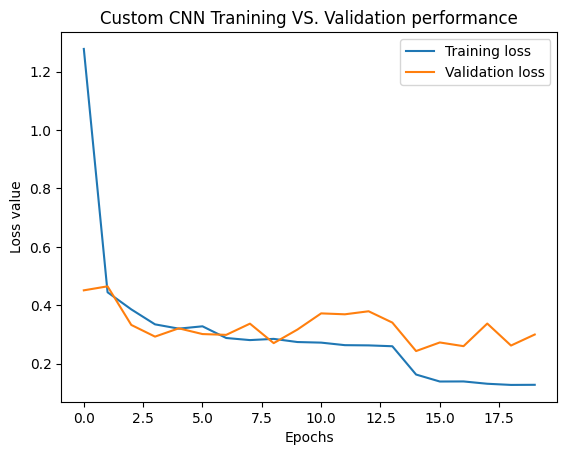

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Custom CNN Tranining VS. Validation performance')
plt.show()

In [26]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 [==============================] - 12s 15ms/step


In [27]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.94      0.92      0.93       933
           b       0.96      0.97      0.96      1014
           c       0.94      0.96      0.95       980
           d       0.97      0.95      0.96       974
           e       0.95      0.94      0.95       981
           f       0.98      0.94      0.96      1046
           g       0.98      0.92      0.95       981
           h       0.95      0.96      0.96       980
           i       0.96      0.91      0.94       952
           j       0.95      0.97      0.96       926
           k       0.99      0.95      0.97      1002
           l       0.90      0.97      0.94       997
           m       0.97      0.96      0.96       974
           n       0.91      0.96      0.93      1011
           o       0.90      0.97      0.93       949
           p       0.96      0.96      0.96      1005
           q       0.98      0.94      0.

## 4.2 EfficientNetB7

In [28]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

258076736/258076736 [==============================] - 1s 0us/step


In [29]:
EffNetB7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 1, 1, 2560)        64097687  
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2622464   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 26)                13338     
                                                      

In [30]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

NameError: name 'EffNetB7' is not defined

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('EfficientNetB7 Training vs Validation Performance')
plt.show()

In [ ]:
#Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

In [ ]:
print('\t The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.3 MobileNetV2

In [56]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [57]:
MobNetV2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1, 1, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 26)                13338     
                                                      

In [58]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.4 VGG19

In [59]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

80134624/80134624 [==============================] - 0s 0us/step


In [60]:
VG.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 26)                13338     
                                                                 
Total params: 21087834 (80.44 MB)
Trainable params: 21087834 (80.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.5 DenseNet121

In [31]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [32]:
Den.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 26)                13338     
                                                                 
Total params: 8625242 (32.90 MB)
Trainable params: 8541594 (32.58 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [33]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [44]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 1.8398 - accuracy: 0.5022
Epoch 1: val_loss improved from inf to 0.80073, saving model to DenseNet121_model.keras
1398/1398 [==============================] - 336s 221ms/step - loss: 1.8398 - accuracy: 0.5022 - val_loss: 0.8007 - val_accuracy: 0.7844 - lr: 1.0000e-05
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.7735
Epoch 2: val_loss improved from 0.80073 to 0.47372, saving model to DenseNet121_model.keras
1398/1398 [==============================] - 307s 219ms/step - loss: 0.8099 - accuracy: 0.7735 - val_loss: 0.4737 - val_accuracy: 0.8696 - lr: 1.0000e-05
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.8381
Epoch 3: val_loss improved from 0.47372 to 0.35318, saving model to DenseNet121_model.keras
1398/1398 [==============================] - 306s 219ms/step - loss: 0.5705 - accuracy: 0.8381 - val_loss: 0.3532 - val_accura

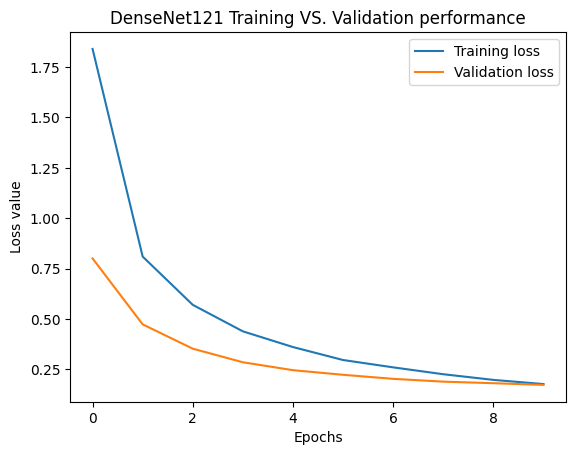

In [45]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [46]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 46s 55ms/step


In [47]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.92      0.95      0.93       933
           b       0.95      0.97      0.96      1014
           c       0.94      0.94      0.94       980
           d       0.97      0.96      0.97       974
           e       0.93      0.93      0.93       981
           f       0.97      0.96      0.96      1046
           g       0.94      0.95      0.95       981
           h       0.96      0.95      0.95       980
           i       0.94      0.94      0.94       952
           j       0.96      0.96      0.96       926
           k       0.95      0.96      0.96      1002
           l       0.93      0.93      0.93       997
           m       0.95      0.98      0.96       974
           n       0.97      0.92      0.95      1011
           o       0.92      0.97      0.94       949
           p       0.98      0.94      0.96      1005
           q       0.97      0.96      0

# 5. Evaluation & Comparison

In [40]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

		The Evaluation results of CNN/Pre-trained models
                accuracy  precision  recall  F1-Score
Custom CNN          0.95       0.96    0.95      0.95
EfficientNetB7      0.93       0.94    0.93      0.93
MobileNetV7         0.71       0.72    0.71      0.71
VGG19               0.96       0.96    0.96      0.96
DenseNet121         0.95       0.95    0.95      0.95


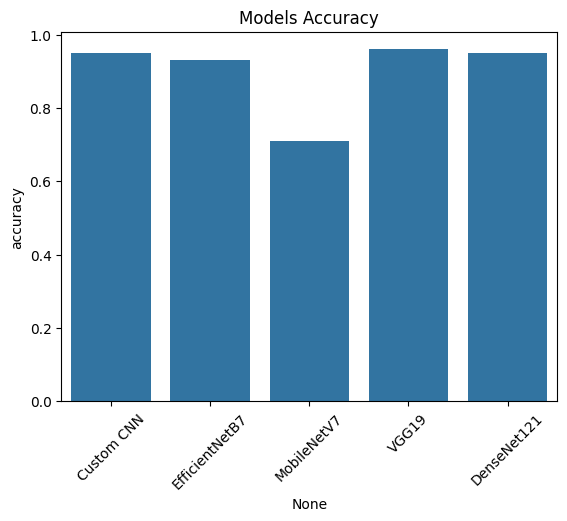

In [41]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.title('Models Accuracy')
plt.show()

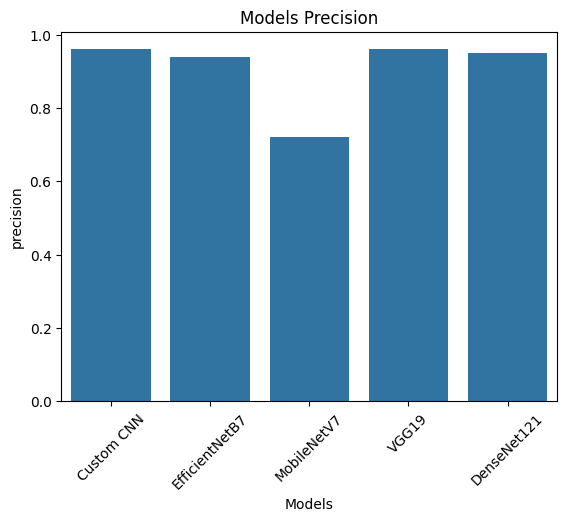

In [42]:

sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title('Models Precision')
plt.show()

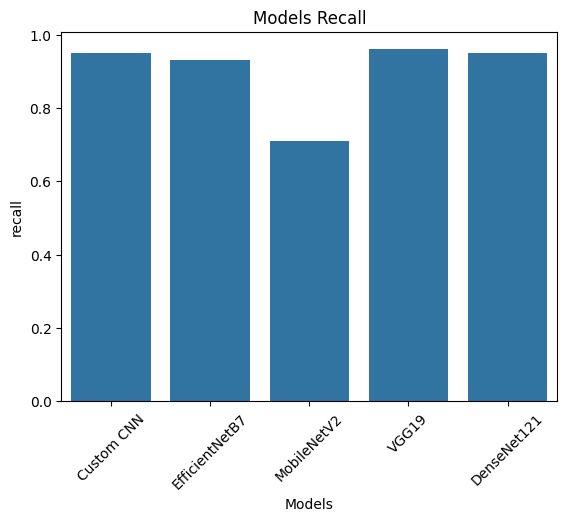

In [36]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

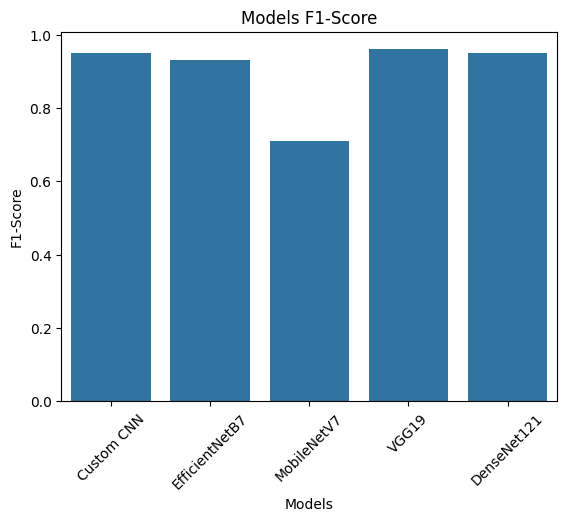

In [43]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

- `VGG19` shows an outstanding performance amongst all models.
- Due technical reasons in the next section `Post-processing`, it shows that `DenseNet121` has better performance than `VGG19` on external images which will be used.
- The `Custom CNN` shows an excellent performance on the testing set on few number of epochs, it can be enhanced with more epochs and maybe data augmentation.

# 6 Post-Processsing

**This section is about `Computer Vision` techniques**

The image will be taken from the user/externally to be processed & input into our model. Some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, whether it is text or handwritten, these techniques are following:
- ***Binarization:*** The binarization function applies Ostu's binarization to grayscale image, producing a binary image.
- ***Dilate:*** The dialte function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.
- ***Find Rectangles:*** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their x-coordinate (From left to right).
- ***Extract Characters:*** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

In [52]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/content/DenseNet121_model.keras'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image
    del _, bin_img, full_dil_img                          # for better memory usage

    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])

## 6.1 Testing

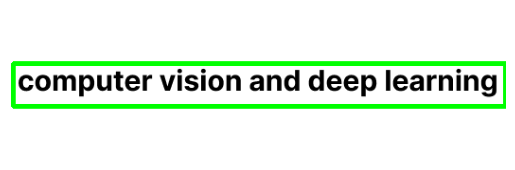

--> gomputervisionanddeepiearning


In [53]:
# testing 1
img = read_image('/content/Frame 15.png')
text = extract(img)
print('-->',text)

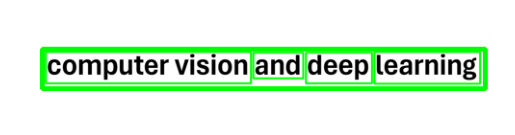

--> gompuiervisionanddeeptearning


In [54]:
# testing 2
img = read_image('/content/__results___69_0.png')
text = extract(img)
print('-->',text)

# 7 Conclusion

This OCR implemention combines low-level computer vision techniques with deep learning for character recognition.
